In [3]:
#import dependencies
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray 
import pprint
import h5py
from pathlib import Path
from datetime import datetime
import pandas as pd

In [7]:
# code and files from Sofia with my data directory
data_dir = Path("C:/Users/Ashley Howard/ESS569/MLGEO_Sublacial_Lakes/ATL11_LakeVostok/")
atl11 = sorted(list(data_dir.glob("*.h5")))

#inspect one of the downloaded files --> top level keys
with h5py.File(atl11[0], "r") as f:
    print("keys:", list(f.keys()))

#inspect one of the pt groups --> next level
with h5py.File(atl11[0], "r") as f:
    pt1 = f["pt1"]
    print("pt1 keys:", list(pt1.keys()))

    # each pt group has the same subgroups, we want: h_corr, delta_time, latitude, longitude (maybe quality summary, and ref poiint) - need to extract

#inspect a specfic set within the pt. group --> next level 
with h5py.File(atl11[0], "r") as f:
    h = f["pt1"]["h_corr"]
    print("shape:", h.shape)


keys: ['METADATA', 'ancillary_data', 'orbit_info', 'pt1', 'pt2', 'pt3', 'quality_assessment']
pt1 keys: ['crossing_track_data', 'cycle_number', 'cycle_stats', 'delta_time', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'ref_surf']
shape: (25430, 24)


In [83]:
ATLAS_EPOCH = pd.Timestamp("2018-01-01")

def extract_atl11(h5_file, beam="pt1"):
    """
    Extract ATL11 elevation time series from beam ("pt1") into a DF
    """

    rows = []

    with h5py.File(h5_file, "r") as f:
        pt = f[beam]

        h_corr = pt["h_corr"][:]
        delta_time = pt["delta_time"][:]
        #quality = pt["quality_summary"][:]
        h_corr_sigma = pt["h_corr_sigma"][:]

        lat = pt["latitude"][:]
        lon = pt["longitude"][:]
        ref_pt = pt["ref_pt"][:]

        n_ref, n_cycle = h_corr.shape

        for i in range(n_ref):
            for j in range(n_cycle):

                h = h_corr[i, j]
                if not np.isfinite(h):
                    continue
                    
                sig = h_corr_sigma[i, j]
                if not np.isfinite(sig):
                    continue

                dt = delta_time[i, j]
                if (not np.isfinite(dt)) or (dt > 1e20):
                    continue

                #q = quality[i, j] if quality.ndim == 2 else quality[i]
                #if q != 0:
                 #   continue

                rows.append({
                    #"ref_pt": ref_pt[i],
                    #"time": ATLAS_EPOCH + pd.to_timedelta(dt, unit="s"), had to comment this out because otherwise the file was too huge
                    "lat": lat[i],
                    "lon": lon[i],
                    "h_corr": h,
                    #"quality": q,
                    "h_corr_sigma": sig
                    
                })

    return pd.DataFrame(rows)


In [84]:
dfs = []

for file in atl11:
    for beam in ["pt1", "pt2", "pt3"]:
        df = extract_atl11(file, beam)
        dfs.append(df)

atl11_df = pd.concat(dfs, ignore_index=True)

In [85]:
processed_dir = data_dir / "processed"
processed_dir.mkdir(exist_ok=True)

out = processed_dir / "atl11_lakevostok.csv"
atl11_df.to_csv(out, index=False)
atl11_df = pd.read_csv(out)

In [86]:
atl11_df

,lat,lon,h_corr,h_corr_sigma
0,-65.525353,112.237583,-20.057898,0.036002
1,-65.525353,112.237583,-19.827234,0.061815
2,-65.525881,112.237638,-21.136070,0.052649
3,-65.525881,112.237638,-20.058670,0.036610
4,-65.525881,112.237638,-20.910269,0.067386
...,...,...,...,...
132229525,-78.993144,105.971513,3445.150600,0.011135
132229526,-78.993144,105.971513,3445.111000,0.011150
132229527,-78.993144,105.971513,3445.194300,0.010704
132229528,-78.993144,105.971513,3445.179400,0.013734


## Data Characterization
Histograms - are the data normally distributed, is there correlation, covariance, missing data? Mean, stdev? Error?

The following sections don't work very well because the "missing" data is practically infinity.

(array([1.32228162e+08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.36800000e+03]),
 array([-2.03725360e+02,  1.13427450e+37,  2.26854900e+37,  3.40282350e+37,
         4.53709800e+37,  5.67137250e+37,  6.80564700e+37,  7.93992150e+37,
         9.07419600e+37,  1.02084705e+38,  1.13427450e+38,  1.24770195e+38,
         1.36112940e+38,  1.47455685e+38,  1.58798430e+38,  1.70141175e+38,
         1.81483920e+38,  1.92826665e+38,  2.04169410e+38,  2.15512155e+38,
         2.26854900e+38,  2.38197645e+38,  2.49540390e+38,  2.60883135e+38

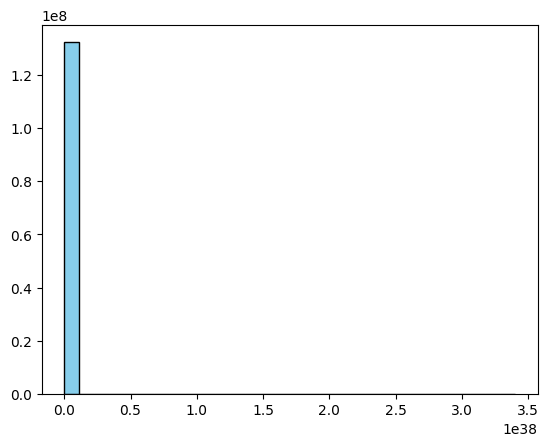

In [88]:
plt.hist(atl11_df.h_corr, bins=30, color='skyblue', edgecolor='black') 

(array([1.32228162e+08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.36800000e+03]),
 array([2.49445040e-03, 1.13427450e+37, 2.26854900e+37, 3.40282350e+37,
        4.53709800e+37, 5.67137250e+37, 6.80564700e+37, 7.93992150e+37,
        9.07419600e+37, 1.02084705e+38, 1.13427450e+38, 1.24770195e+38,
        1.36112940e+38, 1.47455685e+38, 1.58798430e+38, 1.70141175e+38,
        1.81483920e+38, 1.92826665e+38, 2.04169410e+38, 2.15512155e+38,
        2.26854900e+38, 2.38197645e+38, 2.49540390e+38, 2.60883135e+38,
        2.72225880e+38

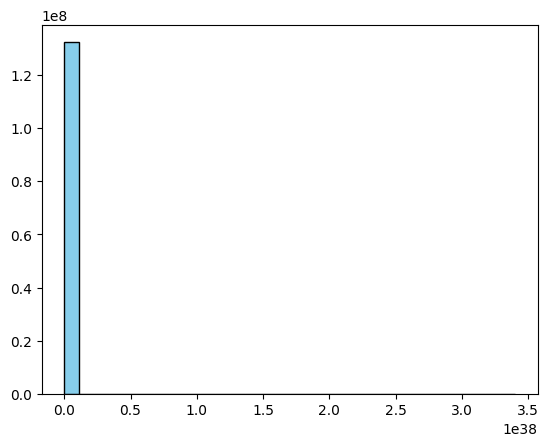

In [89]:
plt.hist(atl11_df.h_corr_sigma, bins=30, color='skyblue', edgecolor='black')

In [91]:
print(atl11_df.dtypes)

lat             float64
lon             float64
h_corr          float64
h_corr_sigma    float64
dtype: object


In [92]:
atl11_df[['h_corr','h_corr_sigma']].describe()


,h_corr,h_corr_sigma
count,1.322295e+08,1.322295e+08
mean,3.520441e+33,3.520441e+33
std,1.094501e+36,1.094501e+36
min,-2.037254e+02,2.494450e-03
25%,2.468604e+03,1.077347e-02
50%,3.050862e+03,1.563184e-02
75%,3.427142e+03,2.881564e-02
max,3.402823e+38,3.402823e+38


In [97]:
print((atl11_df['h_corr'] > 1e30).sum())
print((atl11_df['h_corr_sigma'] > 1e30).sum())
flag_fraction = (atl11_df['h_corr'] > 1e6).mean() #this tells you what fraction of the data was missing
print(flag_fraction)

1368
1368
1.0345646694804103e-05


In [98]:
#masking out the missing data
atl11_df['h_corr'] = atl11_df['h_corr'].mask(atl11_df['h_corr'] > 1e30)
atl11_df['h_corr_sigma'] = atl11_df['h_corr_sigma'].mask(atl11_df['h_corr_sigma'] > 1e30)

In [99]:
atl11_df[['h_corr','h_corr_sigma']].describe()


,h_corr,h_corr_sigma
count,1.322282e+08,1.322282e+08
mean,2.747446e+03,2.643591e-02
std,8.986336e+02,9.999966e-02
min,-2.037254e+02,2.494450e-03
25%,2.468594e+03,1.077343e-02
50%,3.050852e+03,1.563168e-02
75%,3.427136e+03,2.881503e-02
max,3.558453e+03,1.499783e+01


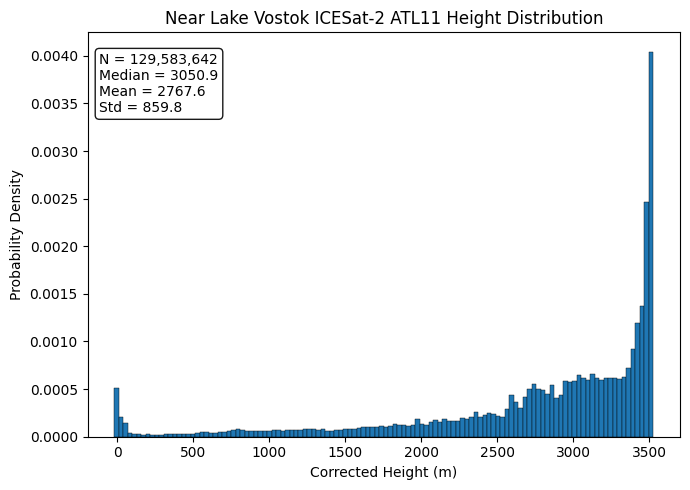

In [105]:
import matplotlib.pyplot as plt

data = atl11_df['h_corr'].dropna()

# percentile clipping for visual clarity
lo, hi = data.quantile([0.01, 0.99])
plot_data = data[(data >= lo) & (data <= hi)]

plt.figure(figsize=(7,5))

plt.hist(
    plot_data,
    bins=120,
    density=True,
    edgecolor='black',
    linewidth=0.3
)

plt.xlabel("Corrected Height (m)")
plt.ylabel("Probability Density")
plt.title("Near Lake Vostok ICESat-2 ATL11 Height Distribution")

# summary stats box
txt = (
    f"N = {len(plot_data):,}\n"
    f"Median = {plot_data.median():.1f}\n"
    f"Mean = {plot_data.mean():.1f}\n"
    f"Std = {plot_data.std():.1f}"
)

plt.text(
    0.02, 0.95, txt,
    transform=plt.gca().transAxes,
    ha='left', va='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9)
)

plt.tight_layout()
plt.show()


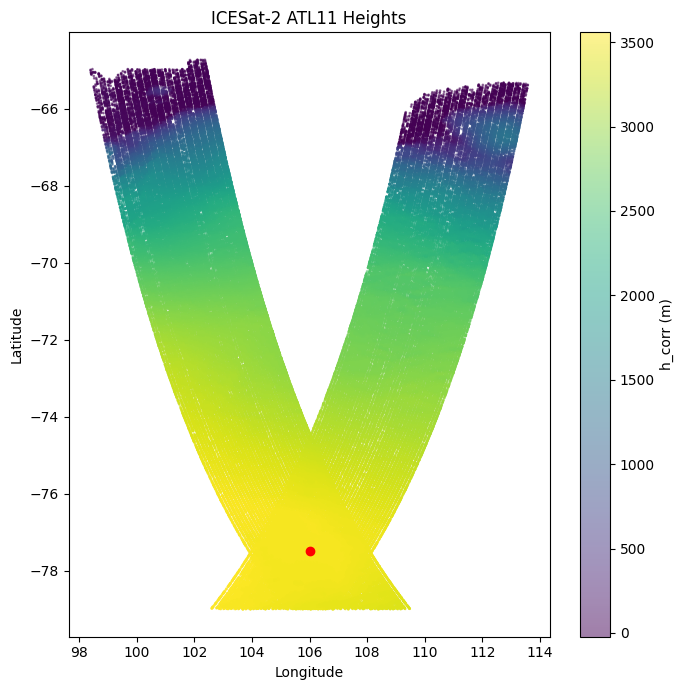

In [107]:
plt.figure(figsize=(7,7))
plot_df = atl11_df.sample(200000)   # keep 200k points so that the memory doesn't get overwhelmed

sc = plt.scatter(
    plot_df['lon'],
    plot_df['lat'],
    c=plot_df['h_corr'],
    s=1,
    alpha=0.5
)
plt.scatter(106.0001,-77.5001,color = "red") #lake Vostok location
plt.colorbar(sc, label="h_corr (m)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("ICESat-2 ATL11 Heights")
plt.tight_layout()
plt.show()



In [4]:
#this section was built by ChatGPT
from pyproj import Geod
from shapely.geometry import Polygon

def calculate_geographic_area(lon_min, lat_min, lon_max, lat_max):
    """
    Calculates the area of a bounding box in square meters.

    Args:
        lon_min (float): Minimum longitude (west).
        lat_min (float): Minimum latitude (south).
        lon_max (float): Maximum longitude (east).
        lat_max (float): Maximum latitude (north).

    Returns:
        float: The area in square meters.
    """
    # Define the bounding box coordinates as a polygon
    # Coordinates format for shapely is (longitude, latitude)
    # The polygon must be closed (first and last point are the same)
    coords = [
        (lon_min, lat_min),
        (lon_min, lat_max),
        (lon_max, lat_max),
        (lon_max, lat_min),
        (lon_min, lat_min) # Closing point
    ]
    poly = Polygon(coords)

    # Use the WGS84 ellipsoid model for geodesic calculations
    # The 'a' parameter could also be used to specify the WGS84 semi-major axis
    # Geod is built into geopandas but can be used with shapely polygons directly
    geod = Geod(ellps="WGS84") 

    # Calculate the area and perimeter. geometry_area_perimeter returns a tuple (area, perimeter)
    # We take the absolute value of the area, as the sign depends on the winding order
    area_m2 = abs(geod.geometry_area_perimeter(poly)[0])
    
    return area_m2

# Example Usage:
# Bounding box for a 1x1 degree square at the equator (approx 0,0)
# Note: Area will vary significantly at different latitudes
min_lon = 105.0
min_lat = -78.5
max_lon = 107.0
max_lat = -76.5

area_sq_meters = calculate_geographic_area(min_lon, min_lat, max_lon, max_lat)
area_sq_km = area_sq_meters / 1000**2.0

print(f"Area: {area_sq_meters:.3f} square meters")
print(f"Area: {area_sq_km:.3f} square kilometers")



Area: 10791365475.812 square meters
Area: 10791.365 square kilometers


In [9]:
total_ice_area_km2 = 15000000
antarctic_ice_area_km2 = 14000000
sampled_region = area_sq_km

import os

file_path = 'C:/Users/Ashley Howard/ESS569/MLGEO_Sublacial_Lakes/ATL11_LakeVostok/processed/atl11_lakevostok.csv'

try:
    file_size_bytes = os.path.getsize(file_path)
    print(f"The file size is: {file_size_bytes*1e-9} Gb")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except PermissionError:
    print(f"Error: Insufficient permissions to access '{file_path}'.")


The file size is: 7.968652960000001 Gb


In [11]:
#how many Gb do we need to look at all of the ice area?

total_filesize = file_size_bytes*1e-9/sampled_region*total_ice_area_km2
antarctic_filesize = file_size_bytes*1e-9/sampled_region*antarctic_ice_area_km2

print(f"We need: {total_filesize/1000:.3f} Tb to do an atlas")
print(f"We need: {antarctic_filesize/1000:.3f} Tb to do an Antarctic study")

We need: 11.076 Tb to do an atlas
We need: 10.338 Tb to do an Antarctic study
